In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !pip install distython

In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
%matplotlib inline
import sys
sys.path.append("/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Code")
np.set_printoptions(precision=5, suppress=True)

In [ ]:
ds_path = '/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Survey+dataset/3_filtered_values.csv'

df = pd.read_csv(ds_path)

# Clustering


## DNA selection

In [ ]:
columns = [
             "InternetUsers",
             "Concern_environmental_impacts",
             "Would_subsribe_car_sharing_if_available", 
             "Preference_tolls_or_traffic_limitation",
             "Gender",
             "grouped_Age",
             #"grouped_Region_3", 
             #"Country", 
             ]
df_DNA = df[columns]
#categorical_ix = [0, 1, 2, 4, 5, 6, 7]
categorical_ix = [2,3,4,5]

In [ ]:
df_DNA["Would_subsribe_car_sharing_if_available"].unique()

array(['Maybe yes, maybe not. I would need to test the service before taking a decision',
       'No, I would not be interested in this service',
       "Don't know / No answer",
       'Yes without any influence on my car ownership',
       'Yes, instead of purchasing a new car',
       'Yes and I would give up one car I currently own',
       "Yes I'm already client of a car sharing service"], dtype=object)

In [ ]:
df_DNA["grouped_Age"].unique()

array(['47:51', '23:27', '54:85', '35:39', '39:43', '27:30', '16:23',
       '43:47', '30:35', '51:54'], dtype=object)

In [ ]:
df_DNA.loc[df_DNA["grouped_Age"]==2]

,InternetUsers,Concern_environmental_impacts,Would_subsribe_car_sharing_if_available,Preference_tolls_or_traffic_limitation,Gender,grouped_Age


In [ ]:
cleanup_nums = {"Concern_environmental_impacts":
                  {
                      '1': 1,
                      '2': 2,
                      '3': 3,
                      '4': 4,
                      '5': 5,
                      '6': 6,
                      '7': 7,
                      '8': 8,
                      '9': 9,
                      '10': 10,
                      "Don't know": 0
                  },
                "Would_subsribe_car_sharing_if_available":
                  {
                      "Don't know / No answer": 0,
                      'No, I would not be interested in this service': 1,
                      'Maybe yes, maybe not. I would need to test the service before taking a decision': 2,
                      'Yes without any influence on my car ownership': 3,
                      'Yes, instead of purchasing a new car': 4,
                      'Yes and I would give up one car I currently own': 5,
                      "Yes I'm already client of a car sharing service": 6
                  },
                "Preference_tolls_or_traffic_limitation":
                  {
                      'No preferences': 0,
                      'Probably more acceptable to limit road traffic': 1,
                      'Probably more acceptable to pay for less congestion': 2,
                      'Definitely more acceptable to pay for less congestion': 3,
                      'Definitely more acceptable to limit road traffic': 4
                  },
                "Gender":
                  {
                      'Female': 0,
                      'Male': 1
                  },
                "grouped_Age":
                  {
                      '16:23': 0,
                      '23:27': 1,
                      '23:27': 2,
                      '27:30': 3,
                      '30:35': 4,
                      '35:39': 5, 
                      '39:43': 6,
                      '43:47': 7,
                      '47:51': 8,
                      '51:54': 9,
                      '54:85': 10,
                  }
                }

In [ ]:
df_DNA = df_DNA.replace(cleanup_nums)

In [ ]:
df_DNA.dtypes

InternetUsers                              int64
Concern_environmental_impacts              int64
Would_subsribe_car_sharing_if_available    int64
Preference_tolls_or_traffic_limitation     int64
Gender                                     int64
grouped_Age                                int64
dtype: object

In [ ]:
df_DNA

,InternetUsers,Concern_environmental_impacts,Would_subsribe_car_sharing_if_available,Preference_tolls_or_traffic_limitation,Gender,grouped_Age
0,75,5,2,0,0,8
1,71,8,2,1,1,2
2,63,6,1,0,1,8
3,85,8,0,2,1,10
4,50,8,2,0,1,5
...,...,...,...,...,...,...
26600,63,3,4,2,0,3
26601,63,5,0,0,0,4
26602,63,7,2,0,1,4
26603,63,7,4,1,1,5


### Normalize variables

In [ ]:
x = df_DNA.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_DNA = pd.DataFrame(x_scaled)
df_DNA.columns = columns

In [ ]:
x_original = min_max_scaler.inverse_transform(x_scaled)
df_DNA_original = pd.DataFrame(x_original)

In [ ]:
df_DNA

,InternetUsers,Concern_environmental_impacts,Would_subsribe_car_sharing_if_available,Preference_tolls_or_traffic_limitation,Gender,grouped_Age
0,0.758621,0.5,0.333333,0.00,0.0,0.8
1,0.689655,0.8,0.333333,0.25,1.0,0.2
2,0.551724,0.6,0.166667,0.00,1.0,0.8
3,0.931034,0.8,0.000000,0.50,1.0,1.0
4,0.327586,0.8,0.333333,0.00,1.0,0.5
...,...,...,...,...,...,...
26600,0.551724,0.3,0.666667,0.50,0.0,0.3
26601,0.551724,0.5,0.000000,0.00,0.0,0.4
26602,0.551724,0.7,0.333333,0.00,1.0,0.4
26603,0.551724,0.7,0.666667,0.25,1.0,0.5


## Distance metrics
The implementation of the distance metrics are taken from the library **_distython_**: [https://github.com/KacperKubara/distython](https://github.com/KacperKubara/distython)


### Heterogeneous Euclidean-Overlap Metric (HEOM)
HEOM is a distance metric taken from [this paper](https://arxiv.org/pdf/cs/9701101.pdf).

HEOM handles categorical, numerical and missing data

$$
d_a(x,y) = 
\begin{equation}
  \begin{cases}
    1, \text{if $x$ or $y$ unknown, else}\\
    overlap(x,y), \text{if $a$ is nominal, else}\\
    normalized\_euclidean\_dist_a(x,y)
  \end{cases}
\end{equation}
$$

$$
overlap(x,y) = 
\begin{equation}
  \begin{cases}
    1, \text{ if x=y}\\
    0, \text{ else}
  \end{cases}
\end{equation}
$$

$$
normalized\_euclidean\_dist_a(x,y) = \frac{|x-y|}{range_a}\\
range_a = max_a - min_a
$$

$$HEOM(x,y) = \sqrt{\sum_{a=1}^m d_a(x_a, y_a)^2}$$
where:
- $x, y$ are datapoints
- $a$ is a feature


In [ ]:
# Cython Way
from DistanceMetrics.heom_c import HEOM_C
heom_metric = HEOM_C(df_DNA, categorical_ix)

# # Python way
# from DistanceMetrics.heom import HEOM
# heom_metric = HEOM(df_DNA, categorical_ix)

### Heterogeneous Value Difference Metric (HVDM)

## Clustering

#### Scalers

In [ ]:
x = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
print(x.shape)
x_scaled = min_max_scaler.fit_transform(x)
x_scaled

(5, 1)


array([[0.  ],
       [0.25],
       [0.5 ],
       [0.75],
       [1.  ]])

In [ ]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit_transform(x)

array([[-1.41421],
       [-0.70711],
       [ 0.     ],
       [ 0.70711],
       [ 1.41421]])

### DBSCAN

In [ ]:
# metric = 'euclidean'
metric = heom_metric.heom

In [ ]:
min_samples = 200

#### Find eps value

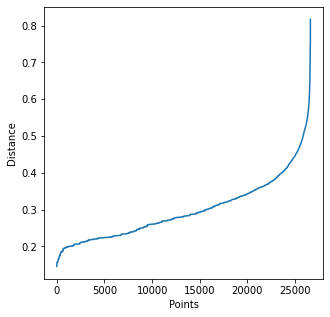

In [ ]:
# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=min_samples+1)
neighbors = nearest_neighbors.fit(df_DNA.values)
distances, indices = neighbors.kneighbors(df_DNA.values)

distances = np.sort(distances[:,min_samples], axis=0)
# i = np.arange(len(distances))
# knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

plt.savefig("Distance_curve.png", dpi=300)


In [ ]:
eps = 0.4

#### Run DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(metric=metric, eps=eps, min_samples=min_samples).fit(df_DNA.values)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

| size | HEOM_C |
| ---- | ------ |
| 2000 | 25s    |
| 4000 | 102s   |


In [ ]:
save_path = f'/content/drive/MyDrive/MIDA2/IntelligentMobilityProject' \
            f'/Code/Data/DBSCAN_heom_eps_{eps}_min_samples_{min_samples}.npy'

In [ ]:
np.save(save_path, labels)

In [ ]:
# labels = np.load(save_path)

In [ ]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
noisy_points = db.labels_==-1
cluster_points = ~noisy_points

In [ ]:
print('DBSCAN')
print(f'eps: {eps}\nmin_samples: {min_samples}')
print("Number of clusters = %d"%n_clusters_)
print("Number of cluster points = %d"%sum(cluster_points))
print("Number of noisy points = %d"%sum(noisy_points))

DBSCAN
eps: 0.4
min_samples: 200
Number of clusters = 21
Number of cluster points = 4798
Number of noisy points = 21807


In [ ]:
(unique, counts) = np.unique(labels, return_counts=True)

In [ ]:
df_clusters = pd.DataFrame({
    'cluster': unique,
    'size': counts
}).sort_values('size')

In [ ]:
# df_clusters[df_clusters['size'] >= 230]

,cluster,size
14,13,232
117,116,241
82,81,241
3,2,250
110,109,256
31,30,265
47,46,297
0,-1,437


In [ ]:
df_clusters = df_clusters.drop(df_clusters[df_clusters['size'] < 230].index)

In [ ]:
df_clusters

,cluster,size
14,13,232
117,116,241
82,81,241
3,2,250
110,109,256
31,30,265
47,46,297
0,-1,437


In [ ]:
df_clusters = df_clusters.merge(pd.DataFrame({'cluster': labels}), how='outer')

In [ ]:
df_clusters.loc[df_clusters['size']=='NaN', 'cluster'] = -1

In [ ]:
df_clusters.loc[~pd.notna(df_clusters['size']), 'cluster'] = -1

In [ ]:
df_clusters

,cluster,size
0,13,232.0
1,13,232.0
2,13,232.0
3,13,232.0
4,13,232.0
...,...,...
26600,-1,NaN
26601,-1,NaN
26602,-1,NaN
26603,-1,NaN


In [ ]:
labels = df_clusters['cluster']

## Plot grids

In [ ]:
import seaborn as sns
sns.set_theme()

def plotGrid(df_DNA):
  # cluster = fcluster(Z[metric], k , criterion='maxclust')
  # df_DNA_clusters = df_DNA[:size]
  df_DNA["cluster"] = labels
  g = sns.PairGrid(df_DNA, 
                   hue="cluster",
                   palette="Set1",
                   height=9,
                   aspect=45/9
                   )
  g.map_diag(sns.histplot)
  #g.map_offdiag(sns.swarmplot)
  g.map_offdiag(sns.stripplot, jitter=0.25, dodge=False)
  g.add_legend()
  return g

In [ ]:
# cluster = fcluster(Z['Euclidean'], 7 , criterion='maxclust')
# df_DNA_clusters = df_DNA[:size]
df_DNA["cluster"] = labels
plt.rcParams['figure.figsize'] = (45.0, 9.0)
sns.stripplot(data=df_DNA, 
            x="Preference_tolls_or_traffic_limitation", 
            y="InternetUsers", 
            hue="cluster",
            jitter=0.45,
            palette="Set1",
            )

In [ ]:
# 5,7,8,9,11,16 20

In [ ]:
g = plotGrid(df_DNA)

In [ ]:
g.fig.savefig("/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Pictures/DBSCAN/heom_eps_0.5.png", dpi=200)